In [1]:
import pandas as pd
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import os, pickle
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

from sklearn.preprocessing import OneHotEncoder

from itertools import product

import sys, os

import trajectory as T                      # trajectory generation
import optimizer as O                       # stochastic gradient descent optimizer
import solver as S                          # MDP solver (value-iteration)
import plot as P


num_data = 355504


np.random.seed(66)

def to_interval(istr):
    c_left = istr[0]=='['
    c_right = istr[-1]==']'
    closed = {(True, False): 'left',
              (False, True): 'right',
              (True, True): 'both',
              (False, False): 'neither'
              }[c_left, c_right]
    left, right = map(pd.to_datetime, istr[1:-1].split(','))
    return pd.Interval(left, right, closed)

re_split = False
frac = [0.4,0.2,0.4]
assert np.sum(frac) == 1
frac = np.cumsum(frac)
print (frac)
data_save_path= 'data/'

def sliding(gs, window_size = 6):
    npr_l = []
    for g in gs:
        npr = np.concatenate([np.zeros([window_size-1, g.shape[1]]),g])
        npr_l.append(sliding_window_view(npr, (window_size, g.shape[1])).squeeze(1))
    return np.vstack(npr_l)

/Users/jamin/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-09-27 22:01:05.573822: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[0.4 0.6 1. ]


# LOADING THE DATA

In [2]:
# if re_split:


aggr_df = pd.read_csv('mimic_iv_hypotensive_cut2.csv',sep = ',', header = 0,converters={1:to_interval}).set_index(['stay_id','time']).sort_index()
# create action bins (four actions in total)
aggr_df['action'] = aggr_df['bolus(binary)']*2 + aggr_df['vaso(binary)']
all_idx = np.random.permutation(aggr_df.index.get_level_values(0).unique())
train_df = aggr_df.loc[all_idx[:int(len(all_idx)*frac[0])]].sort_index()
test_df = aggr_df.loc[all_idx[int(len(all_idx)*frac[0]):int(len(all_idx)*frac[1])]].sort_index()
valid_df = aggr_df.loc[all_idx[int(len(all_idx)*frac[1]):]].sort_index()
# print (np.unique(train_df['action'],return_counts=True)[1]*1./len(train_df))
# pickle.dump([train_df, test_df, valid_df], open(data_save_path+'processed_mimic_hyp_2.pkl','wb'))
drop_columns = ['vaso(amount)','bolus(amount)',\
            'any_treatment(binary)','vaso(binary)','bolus(binary)']




# LOOKING AT THE DATA

## print(len(aggr_df))
aggr_df.head()

# Data for patient with hypotension, two treatment vasopressors and a bolus dose of epinephrine depending on certain features of the patient. In order to do IRL we need to discretize the action space:
* Action 0 = No treatment
* Action 1 = Vaso
* Action 2 = Bolus
* Action 3 = Vaso + Bolus



# We also need to do a bit of data cleaning such as taking care of missing values before running our algorithms on it

In [4]:
# for now drop indicators about bolus and vaso
train_df = train_df.drop(columns=drop_columns)
test_df = test_df.drop(columns=drop_columns)
valid_df = valid_df.drop(columns=drop_columns)

#### imputation
impute_table = pd.read_csv('mimic_iv_hypotensive_cut2_impute_table.csv',sep=',',header=0).set_index(['feature'])
train_df = train_df.fillna(method='ffill')
test_df = test_df.fillna(method='ffill')
valid_df = valid_df.fillna(method='ffill')




for f in impute_table.index:
    train_df[f] = train_df[f].fillna(value = impute_table.loc[f].values[0])
    test_df[f] = test_df[f].fillna(value = impute_table.loc[f].values[0])
    valid_df[f] = valid_df[f].fillna(value = impute_table.loc[f].values[0])


data_non_normalized_df = pd.concat([train_df, valid_df, test_df], axis=0, ignore_index=False).head(num_data).copy()


#### standard normalization ####
normalize_features = ['creatinine', 'fraction_inspired_oxygen', 'lactate', 'urine_output',
                  'alanine_aminotransferase', 'asparate_aminotransferase',
                  'mean_blood_pressure', 'diastolic_blood_pressure',
                  'systolic_blood_pressure', 'gcs', 'partial_pressure_of_oxygen']
mu, std = (train_df[normalize_features]).mean().values,(train_df[normalize_features]).std().values
train_df[normalize_features] = (train_df[normalize_features] - mu)/std
test_df[normalize_features] = (test_df[normalize_features] - mu)/std
valid_df[normalize_features] = (valid_df[normalize_features] - mu)/std




### create data matrix ####
X_train = train_df.loc[:,train_df.columns!='action']
y_train = train_df['action']

X_test = test_df.loc[:,test_df.columns!='action']
y_test = test_df['action']

X_valid = valid_df.loc[:, valid_df.columns!='action']
y_valid = valid_df['action']

In [5]:
X_df = pd.concat([X_train, X_valid, X_test], axis=0, ignore_index=True).copy()
y_df = pd.concat([y_train, y_valid, y_test], axis=0, ignore_index=True).copy()


In [6]:
data_df = pd.concat([train_df, valid_df, test_df], axis=0, ignore_index=False).copy()
# data_df = data_df.head(num_data).copy()
# X_df = X_df.head(num_data).copy()
# y_df = y_df.head(num_data).copy()


In [7]:
print(len(data_df))
print(len(X_df))
print(len(y_df))
print(len(data_non_normalized_df))

355504
355504
355504
355504


# Normalized version of the data

In [8]:
data_df.head()

creatinine  \
stay_id  time                                                     
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)   -0.422008   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)   -0.422008   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)   -0.422008   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)   -0.422008   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)   -0.422008   

                                                     fraction_inspired_oxygen  \
stay_id  time                                                                   
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                 -1.760743   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                 -1.760743   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                 -1.760743   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                 -1.760743   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                 -1.760743   

                                                      lactate  urine_output  \
stay_id  time                                                                 
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29) -0.182521     -0.225783   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29) -0.182521     -0.225783   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)  0.360532     -0.225783   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)  0.360532     -0.225783   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)  0.360532     -0.225783   

                                                     alanine_aminotransferase  \
stay_id  time                                                                   
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                 -0.288689   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                 -0.288689   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                 -0.288689   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                 -0.288689   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                 -0.288689   

                                                     asparate_aminotransferase  \
stay_id  time                                                                    
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                  -0.265706   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                  -0.265706   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                  -0.265706   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                  -0.265706   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                  -0.265706   

                                                     mean_blood_pressure  \
stay_id  time                                                              
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)             0.404836   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)             0.404836   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)             0.404836   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)             0.404836   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)             0.404836   

                                                     diastolic_blood_pressure  \
stay_id  time                                                                   
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                  0.391566   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                  0.391566   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                  0.391566   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                  0.391566   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                  0.391566   

                                                     systolic_blood_pressure  \
stay_id  time                                                                  
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)      

# Unormalized version of the data

In [9]:
data_non_normalized_df.head()

creatinine  \
stay_id  time                                                     
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)         1.0   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)         1.0   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)         1.0   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)         1.0   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)         1.0   

                                                     fraction_inspired_oxygen  \
stay_id  time                                                                   
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                      0.21   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                      0.21   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                      0.21   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                      0.21   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                      0.21   

                                                     lactate  urine_output  \
stay_id  time                                                                
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)      1.8          80.0   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)      1.8          80.0   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)      3.0          80.0   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)      3.0          80.0   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)      3.0          80.0   

                                                     alanine_aminotransferase  \
stay_id  time                                                                   
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                      34.0   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                      34.0   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                      34.0   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                      34.0   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                      34.0   

                                                     asparate_aminotransferase  \
stay_id  time                                                                    
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                       40.0   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                       40.0   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                       40.0   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                       40.0   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                       40.0   

                                                     mean_blood_pressure  \
stay_id  time                                                              
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                 77.0   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                 77.0   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                 77.0   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                 77.0   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                 77.0   

                                                     diastolic_blood_pressure  \
stay_id  time                                                                   
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                      59.0   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                      59.0   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                      59.0   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                      59.0   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                      59.0   

                                                     systolic_blood_pressure  \
stay_id  time                                                                  
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)             

# Matrix form of the data (Normalized and features only)

In [10]:
X_df.head()

,creatinine,fraction_inspired_oxygen,lactate,urine_output,alanine_aminotransferase,asparate_aminotransferase,mean_blood_pressure,diastolic_blood_pressure,systolic_blood_pressure,gcs,partial_pressure_of_oxygen,heart_rate,temperature,respiratory_rate
0,-0.422008,-1.760743,-0.182521,-0.225783,-0.288689,-0.265706,0.404836,0.391566,0.36885,-2.479374,-0.186486,86.0,37.0,19.0
1,-0.422008,-1.760743,-0.182521,-0.225783,-0.288689,-0.265706,0.404836,0.391566,0.36885,-2.479374,-0.186486,86.0,37.0,19.0
2,-0.422008,-1.760743,0.360532,-0.225783,-0.288689,-0.265706,0.404836,0.391566,0.36885,-2.479374,2.356989,86.0,37.0,19.0
3,-0.422008,-1.760743,0.360532,-0.225783,-0.288689,-0.265706,0.404836,0.391566,0.36885,-2.479374,2.356989,86.0,37.0,19.0
4,-0.422008,-1.760743,0.360532,-0.225783,-0.288689,-0.265706,0.404836,0.391566,0.36885,-2.479374,2.356989,86.0,37.0,19.0


# Corresponding output data for training BC (corresponding treatments for each data point in X_df)

In [11]:
y_df.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: action, dtype: float64

# Clustering the feature space to extract a discrete state space form the clusters

In [12]:
num_clusters = 100
kmeans = KMeans(n_clusters= num_clusters , random_state=0)
kmeans.fit(X_df)

KMeans(n_clusters=100, random_state=0)

In [13]:
# Looking at the values counts for each cluster

np.unique(kmeans.labels_, return_counts = True)[1]

array([1573, 5201, 4839, 6302,  755, 2624, 4282, 1152,  206, 2074, 5666,
       2005, 6163, 1005, 3104,  859, 5044, 3901, 1961, 7998, 5495, 3806,
       4191, 3170, 2419,  573, 1358,  721, 8024, 6950, 4028,  423, 7428,
       5084, 6395, 2433,  235, 4324, 7887, 2404, 4686, 8928, 1132,  100,
       3347,  608, 4564, 7711, 1162,  120,   18, 2624, 5086, 3867, 6196,
       1095,  955,  198,  917, 3480, 7076, 2589, 4021, 8352, 1976, 7861,
       1557, 5527, 1369, 4511, 2516, 1746,  560, 6902, 2894,  676, 1189,
       6226, 5385, 1181, 8436, 7384, 5240,  702, 4064, 3613, 1590, 6754,
       2498, 3158,    2, 2687,  283, 4901, 6062, 3146,  678, 3040, 8417,
       7879])

In [14]:
# Assigning each data point to a cluster

X_df['cluster'] = kmeans.labels_.copy()
data_df['cluster'] = kmeans.labels_.copy()
data_non_normalized_df['cluster'] = kmeans.labels_.copy()

In [15]:
print(X_df['cluster'].unique())

[38 77 29 87 12 19 63 99 83 73 65 85 93 98  3 40 30 41 89 20 82 10 78 44
 69 64 94 36 60 32 23  5 46 84 17 45 52 59 86  1 18 51 74 22 16 11 15 61
  9 88 48 26 70 33 80 67 24 14 27 62 66 95 35 37 91 81 34  2  4 47  6 72
 25 42 71 13 97 75 28 54 68 21 92 58 76 31 53 79 55 39  8 49 56 43  0 96
 57 50  7 90]


In [16]:
data_df.head()

creatinine  \
stay_id  time                                                     
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)   -0.422008   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)   -0.422008   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)   -0.422008   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)   -0.422008   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)   -0.422008   

                                                     fraction_inspired_oxygen  \
stay_id  time                                                                   
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                 -1.760743   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                 -1.760743   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                 -1.760743   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                 -1.760743   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                 -1.760743   

                                                      lactate  urine_output  \
stay_id  time                                                                 
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29) -0.182521     -0.225783   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29) -0.182521     -0.225783   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)  0.360532     -0.225783   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)  0.360532     -0.225783   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)  0.360532     -0.225783   

                                                     alanine_aminotransferase  \
stay_id  time                                                                   
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                 -0.288689   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                 -0.288689   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                 -0.288689   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                 -0.288689   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                 -0.288689   

                                                     asparate_aminotransferase  \
stay_id  time                                                                    
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                  -0.265706   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                  -0.265706   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                  -0.265706   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                  -0.265706   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                  -0.265706   

                                                     mean_blood_pressure  \
stay_id  time                                                              
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)             0.404836   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)             0.404836   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)             0.404836   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)             0.404836   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)             0.404836   

                                                     diastolic_blood_pressure  \
stay_id  time                                                                   
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                  0.391566   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                  0.391566   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                  0.391566   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                  0.391566   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                  0.391566   

                                                     systolic_blood_pressure  \
stay_id  time                                                                  
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)      

In [17]:
X_df.head()

,creatinine,fraction_inspired_oxygen,lactate,urine_output,alanine_aminotransferase,asparate_aminotransferase,mean_blood_pressure,diastolic_blood_pressure,systolic_blood_pressure,gcs,partial_pressure_of_oxygen,heart_rate,temperature,respiratory_rate,cluster
0,-0.422008,-1.760743,-0.182521,-0.225783,-0.288689,-0.265706,0.404836,0.391566,0.36885,-2.479374,-0.186486,86.0,37.0,19.0,38
1,-0.422008,-1.760743,-0.182521,-0.225783,-0.288689,-0.265706,0.404836,0.391566,0.36885,-2.479374,-0.186486,86.0,37.0,19.0,38
2,-0.422008,-1.760743,0.360532,-0.225783,-0.288689,-0.265706,0.404836,0.391566,0.36885,-2.479374,2.356989,86.0,37.0,19.0,38
3,-0.422008,-1.760743,0.360532,-0.225783,-0.288689,-0.265706,0.404836,0.391566,0.36885,-2.479374,2.356989,86.0,37.0,19.0,38
4,-0.422008,-1.760743,0.360532,-0.225783,-0.288689,-0.265706,0.404836,0.391566,0.36885,-2.479374,2.356989,86.0,37.0,19.0,38


In [18]:
data_non_normalized_df.head()

creatinine  \
stay_id  time                                                     
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)         1.0   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)         1.0   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)         1.0   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)         1.0   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)         1.0   

                                                     fraction_inspired_oxygen  \
stay_id  time                                                                   
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                      0.21   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                      0.21   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                      0.21   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                      0.21   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                      0.21   

                                                     lactate  urine_output  \
stay_id  time                                                                
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)      1.8          80.0   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)      1.8          80.0   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)      3.0          80.0   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)      3.0          80.0   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)      3.0          80.0   

                                                     alanine_aminotransferase  \
stay_id  time                                                                   
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                      34.0   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                      34.0   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                      34.0   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                      34.0   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                      34.0   

                                                     asparate_aminotransferase  \
stay_id  time                                                                    
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                       40.0   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                       40.0   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                       40.0   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                       40.0   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                       40.0   

                                                     mean_blood_pressure  \
stay_id  time                                                              
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                 77.0   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                 77.0   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                 77.0   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                 77.0   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                 77.0   

                                                     diastolic_blood_pressure  \
stay_id  time                                                                   
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                      59.0   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                      59.0   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                      59.0   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                      59.0   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                      59.0   

                                                     systolic_blood_pressure  \
stay_id  time                                                                  
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)             

# Converting the data into trajectories to input to an IRL algorithm Note this is the same format of trajectories we used for HW1 and HW2.

In [19]:
unique_stay_ids = data_df.index.get_level_values('stay_id').unique()

trajectories = []


for stay_id in unique_stay_ids:


  states, actions = data_df.loc[stay_id]['cluster'], data_df.loc[stay_id]['action']

  trajectory = []
  for i in range(len(states) - 1):
    trajectory.append((states[i], int(actions[i]), states[i+1] ))

  trajectories.append(T.Trajectory(trajectory))

We need to store all possible terminal states from the trajectories list. (Needed to calculate the normalizing constant in MaxEnt)

In [20]:
terminal_states = []

for traj in trajectories:
  terminal_states.append(traj._t[-1][-1])

terminal_states = list(set(terminal_states))

In [21]:
terminal_states

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99]

# Distribution of the treatments given in our data. (Most of the time no treatment is given, might vary on depending on how you cluster the data)

In [22]:
y_df.value_counts()

0.0    195786
1.0    135305
3.0     15978
2.0      8435
Name: action, dtype: int64

# BC Policy example

In [23]:
# Convert states and actions to one-hot encoding
state_encoder = OneHotEncoder(sparse=False, categories= [np.arange(num_clusters)])
action_encoder = OneHotEncoder(sparse=False, categories= [np.arange(4)])


states_onehot = state_encoder.fit_transform(X_df['cluster'].to_numpy().reshape(-1, 1))
actions_onehot = action_encoder.fit_transform(y_df.to_numpy().reshape(-1, 1))


# # Define neural network architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(states_onehot.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(actions_onehot.shape[1], activation='softmax')  # Output layer with softmax for discrete actions
])

# # Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics= ['accuracy'])

# # Train the model
model.fit(states_onehot, actions_onehot,  epochs=5, batch_size=128)

# # Evaluate the model
test_loss = model.evaluate(states_onehot, actions_onehot)
print("Test Loss:", test_loss)


Epoch 1/5
2778/2778 [==============================] - 7s 2ms/step - loss: 0.9160 - accuracy: 0.5621
Epoch 2/5
2778/2778 [==============================] - 6s 2ms/step - loss: 0.9101 - accuracy: 0.5653
Epoch 3/5
2778/2778 [==============================] - 6s 2ms/step - loss: 0.9095 - accuracy: 0.5656
Epoch 4/5
2778/2778 [==============================] - 6s 2ms/step - loss: 0.9091 - accuracy: 0.5656
Epoch 5/5
11110/11110 [==============================] - 16s 1ms/step - loss: 0.9079 - accuracy: 0.5654
Test Loss: [0.9078671336174011, 0.5653522610664368]


In [24]:
bc_policy = np.argmax(model.predict(state_encoder.transform(np.arange(num_clusters).reshape(-1, 1))), axis =1)
bc_policy

4/4 [==============================] - 0s 2ms/step


array([0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0])

[755, 683, 106, 29]
[2825, 1990, 251, 135]
[2859, 1711, 156, 113]
[3728, 2229, 221, 124]
[363, 265, 77, 50]
[2084, 441, 66, 33]
[2149, 1915, 160, 58]
[613, 467, 43, 29]
[180, 22, 4]
[1106, 752, 155, 61]


Text(0.5, 0.98, 'BC Policy')

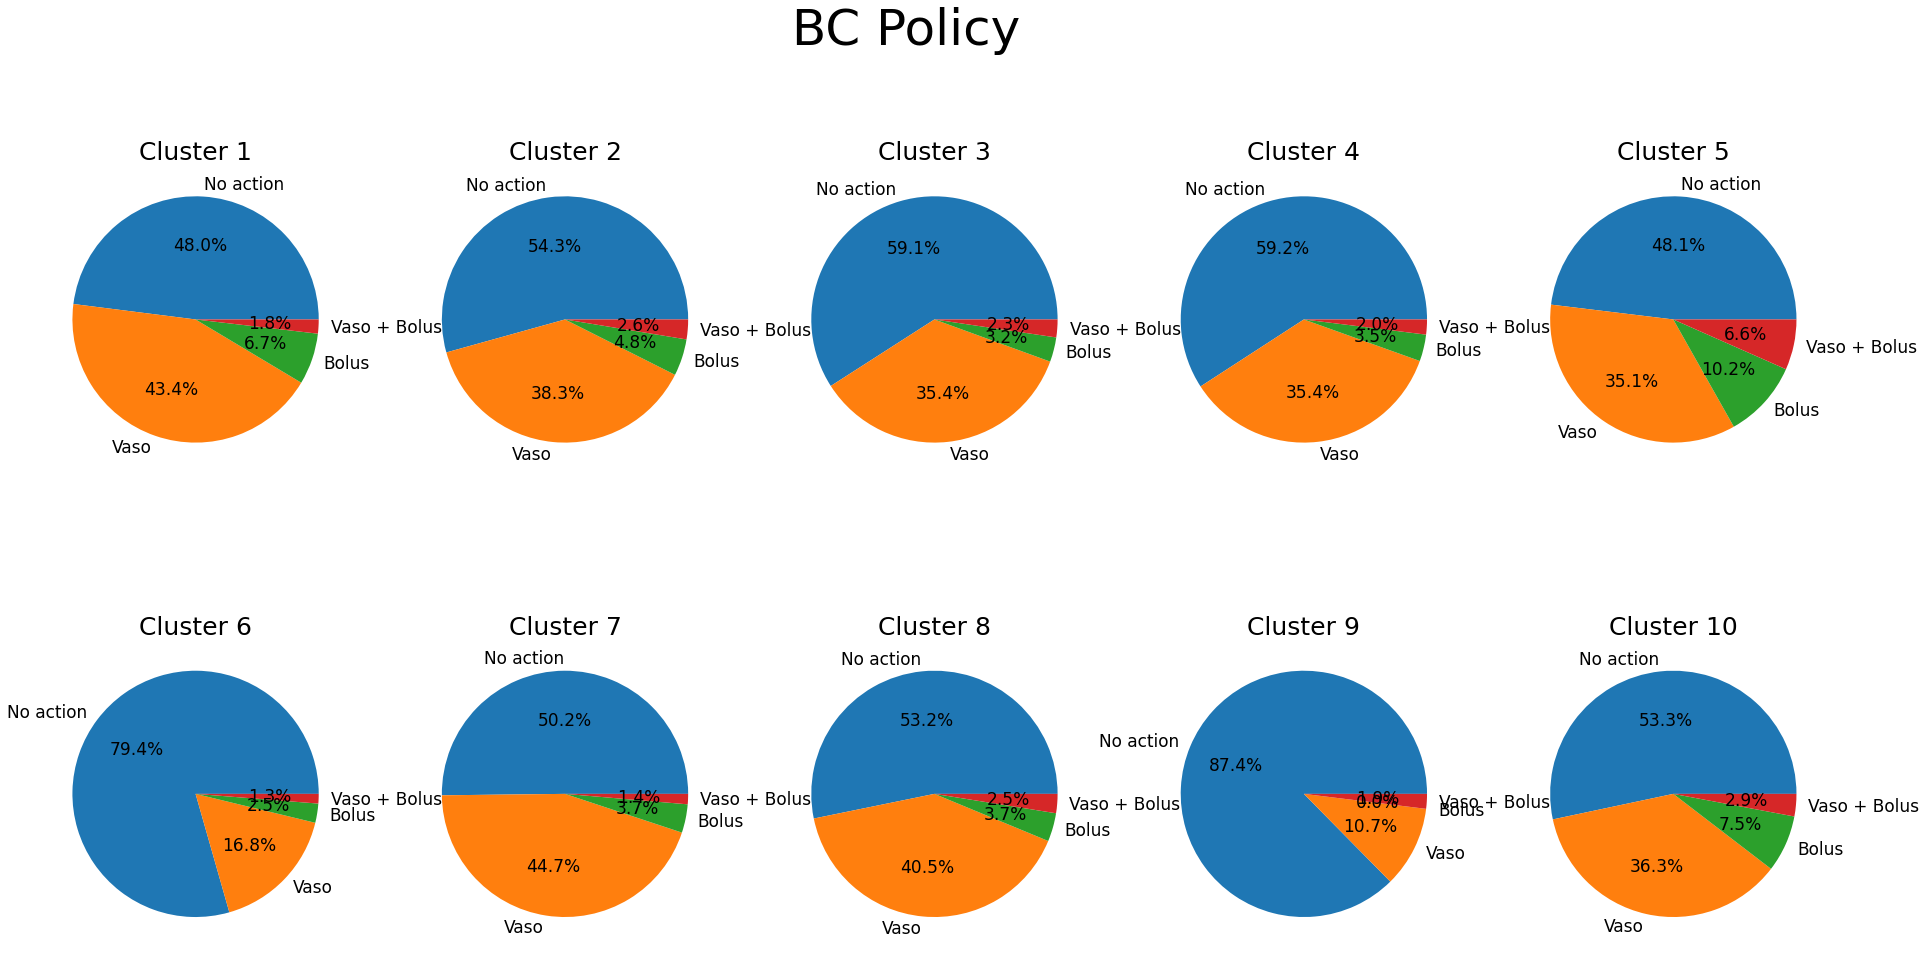

In [223]:
# Old Bar plot code

# fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(32, 16))

# for i, ax in enumerate(axes.flatten()):
#     data_df[data_df['cluster'] == i]['action'].value_counts().plot(kind = 'bar', ax = ax, title = 'Cluster: ' + str(i+ 1))
#     ax.set_ylabel('Counts')
    
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(32, 16))

labels = ['No action', 'Vaso', 'Bolus', 'Vaso + Bolus']

for i, ax in enumerate(axes.flatten()):
    print(data_df[data_df['cluster'] == i]['action'].value_counts().tolist())

for i, ax in enumerate(axes.flatten()):
    policy = data_df[data_df['cluster'] == i]['action'].value_counts().tolist()
    ax.pie(policy, labels=labels, autopct='%1.1f%%', textprops={'fontsize': 17})
    ax.set_title('Cluster ' + str(i+ 1), fontsize=25)

fig.suptitle("BC Policy", fontsize=50)

# Estimating the Transition Dynamics using the MLE (feel free to play around with the smoothing_value)

In [26]:
smoothing_value = 1

p_transition = np.zeros((num_clusters, num_clusters, 4)) + smoothing_value


for traj in trajectories:

  for tran in traj._t:

    p_transition[tran[0], tran[2], tran[1]] +=1

p_transition = p_transition/ p_transition.sum(axis = 1)[:, np.newaxis, :]

In [27]:
p_transition

array([[[4.56599287e-01, 5.47314578e-01, 1.01562500e-01, 3.05825243e-01],
        [1.18906064e-03, 3.83631714e-03, 7.81250000e-03, 4.85436893e-03],
        [1.18906064e-03, 1.27877238e-03, 7.81250000e-03, 4.85436893e-03],
        ...,
        [1.18906064e-03, 2.55754476e-03, 7.81250000e-03, 4.85436893e-03],
        [4.75624257e-03, 3.83631714e-03, 7.81250000e-03, 1.94174757e-02],
        [7.13436385e-03, 1.27877238e-02, 7.81250000e-03, 9.70873786e-03]],

       [[3.50262697e-04, 4.82858522e-04, 4.27350427e-03, 2.84900285e-03],
        [2.35376532e-01, 2.28874940e-01, 7.69230769e-02, 1.70940171e-01],
        [1.05078809e-03, 4.82858522e-04, 4.27350427e-03, 2.84900285e-03],
        ...,
        [3.50262697e-04, 4.82858522e-04, 4.27350427e-03, 2.84900285e-03],
        [9.45709282e-03, 3.38000966e-03, 4.27350427e-03, 2.84900285e-03],
        [3.85288967e-03, 4.34572670e-03, 4.27350427e-03, 2.84900285e-03]],

       [[6.90369348e-04, 5.56173526e-04, 4.69483568e-03, 3.90625000e-03],
        

# Max Causal Entropy

# Feel free to play with the discount factor

In [28]:
discount = 0.9

In [29]:
from maxent import irl, irl_causal

In [30]:
# set up features: we use one feature vector per state (1 hot encoding for each cluster/state)
features = state_encoder.transform(np.arange(num_clusters).reshape(-1, 1))

# choose our parameter initialization strategy:
#   initialize parameters with constant
init = O.Constant(1.0)

# choose our optimization strategy:
#   we select exponentiated stochastic gradient descent with linear learning-rate decay
optim = O.ExpSga(lr=O.linear_decay(lr0=0.2))

# actually do some inverse reinforcement learning
# reward_maxent = maxent_irl(p_transition, features, terminal_states, trajectories, optim, init, eps= 1e-3)

reward_maxent_causal = irl_causal(p_transition, features, terminal_states, trajectories, optim, init, discount,
               eps=1e-3, eps_svf=1e-4, eps_lap=1e-4)

In [31]:
reward_maxent_causal

array([ 1.59203704,  4.61389421,  4.16548542,  6.40112187,  1.24727198,
        2.13771048,  3.53965901,  1.40704097,  1.05639468,  1.82856364,
        5.30573292,  1.80892933,  6.15090189,  1.34355187,  2.49164726,
        1.28562291,  4.39119801,  3.16419164,  1.78522639, 10.70450158,
        5.07088439,  3.076267  ,  3.46095909,  2.53839712,  2.01752481,
        1.17997368,  1.48550538,  1.23647783, 10.69808468,  7.74354634,
        3.28700516,  1.13181241,  8.87268648,  4.49644818,  6.5722664 ,
        2.05045485,  1.07138624,  3.58774558, 10.30456849,  2.03575344,
        3.97514573, 13.94895507,  1.38776421,  1.02977889,  2.69284211,
        1.1981586 ,  3.83927345,  9.78077595,  1.4045121 ,  1.03290522,
        1.00510489,  2.15508513,  4.45485005,  3.10778638,  6.21019894,
        1.3790585 ,  1.32475199,  1.05576142,  1.30935195,  2.78229562,
        8.09974538,  2.14348899,  3.28503474, 11.92454912,  1.79381089,
       10.18172632,  1.58299368,  5.11976966,  1.49713225,  3.79

In [224]:
print(len(reward_maxent_causal))

100


# Finding top and bottom 5 reward clusters

In [404]:
k = 5

min_sorted = np.sort(reward_maxent_causal)
min_five = min_sorted[:k]
min_five_indices = []

for j in range(len(min_five)):
    for i in range(len(reward_maxent_causal)):
        if min_five[j] == reward_maxent_causal[i]:
            min_five_indices.append(i)

print(min_five)
print(min_five_indices)

[1.00059479 1.00510489 1.02977889 1.03290522 1.05576142]
[90, 50, 43, 49, 57]


In [405]:
max_sorted = np.sort(reward_maxent_causal)
max_five = max_sorted[-k:]
max_five_indices = []

for j in range(len(max_five)):
    for i in range(len(reward_maxent_causal)):
        if max_five[j] == reward_maxent_causal[i]:
            max_five_indices.append(i)

print(max_five)
print(max_five_indices)

[10.70450158 11.92454912 12.04672784 12.10828585 13.94895507]
[19, 63, 80, 98, 41]


In [406]:
min_five_indices = np.flip(min_five_indices)
max_five_indices = np.flip(max_five_indices)
print(max_five_indices)
print(min_five_indices)

[41 98 80 63 19]
[57 49 43 50 90]


# average values for bigass plot

In [407]:
viz_df = data_non_normalized_df
viz_df = viz_df.drop(['action'], axis=1)

color_matrix_y_labels = viz_df.drop(['cluster'], axis=1).columns.tolist()
color_matrix_x_labels = max_five_indices.tolist()
for i in min_five_indices :
    color_matrix_x_labels.append(i)
print(color_matrix_y_labels)
print(color_matrix_x_labels)


color_matrix = []

for i in max_five_indices:
    df = viz_df[viz_df['cluster'] == i].mean()
    lst = df.drop(['cluster']).tolist()
    color_matrix.append(lst)    

    
for i in min_five_indices:
    df = viz_df[viz_df['cluster'] == i].mean()
    lst = df.drop(['cluster']).tolist()
    color_matrix.append(lst)
    
color_matrix = np.transpose(color_matrix)

color_matrix

['creatinine', 'fraction_inspired_oxygen', 'lactate', 'urine_output', 'alanine_aminotransferase', 'asparate_aminotransferase', 'mean_blood_pressure', 'diastolic_blood_pressure', 'systolic_blood_pressure', 'gcs', 'partial_pressure_of_oxygen', 'heart_rate', 'temperature', 'respiratory_rate']
[41, 98, 80, 63, 19, 57, 49, 43, 50, 90]


array([[1.44830869e+00, 1.55752049e+00, 1.55266714e+00, 1.46869612e+00,
        1.54586147e+00, 2.33232323e+00, 2.23166667e+00, 1.70250000e+00,
        1.61111111e+00, 3.40000000e+00],
       [4.86748059e-01, 4.90741357e-01, 4.92311917e-01, 4.98975295e-01,
        4.88842627e-01, 6.17222222e-01, 6.96666667e-01, 5.29000000e-01,
        4.80555556e-01, 3.75000000e-01],
       [1.87891577e+00, 2.05072908e+00, 1.84419354e+00, 1.95910560e+00,
        2.03134534e+00, 8.22786195e+00, 7.86791667e+00, 3.19000000e+00,
        2.28888889e+00, 5.30000000e+00],
       [1.11101058e+02, 1.03910637e+02, 1.11110400e+02, 1.08104286e+02,
        1.00218930e+02, 4.63484848e+01, 3.14333333e+01, 1.06720000e+02,
        6.64444444e+01, 3.75000000e+01],
       [1.55241375e+02, 1.37730664e+02, 1.56477003e+02, 1.15467313e+02,
        1.07772568e+02, 7.67883838e+02, 3.76108333e+02, 4.43860000e+02,
        6.77222222e+02, 1.05500000e+02],
       [2.66469982e+02, 2.56192171e+02, 2.77457978e+02, 1.82777718e+02,
   

In [408]:
v = reward_maxent_causal
normalized_reward_maxent_causal = (v - v.min()) / (v.max() - v.min())
print(normalized_reward_maxent_causal)

[4.56769997e-02 2.79054594e-01 2.44424048e-01 4.17081929e-01
 1.90508438e-02 8.78192809e-02 1.96091564e-01 3.13897799e-02
 4.30941742e-03 6.39439151e-02 3.32485198e-01 6.24275604e-02
 3.97757476e-01 2.64865262e-02 1.15153768e-01 2.20126807e-02
 2.61855799e-01 1.67094274e-01 6.05969856e-02 7.49431324e-01
 3.14347880e-01 1.60303866e-01 1.90013581e-01 1.18764252e-01
 7.85373589e-02 1.38534058e-02 3.74495748e-02 1.82172131e-02
 7.48935748e-01 5.20757177e-01 1.76579144e-01 1.01339179e-02
 6.07960508e-01 2.69984254e-01 4.30299396e-01 8.10805415e-02
 5.46721347e-03 1.99805283e-01 7.18544549e-01 7.99451533e-02
 2.29724141e-01 1.00000000e+00 2.99010388e-02 2.25388375e-03
 1.30692017e-01 1.52578242e-02 2.19230744e-01 6.78092127e-01
 3.11944756e-02 2.49532993e-03 3.48313986e-04 8.91611223e-02
 2.66771636e-01 1.62738103e-01 4.02336978e-01 2.92286976e-02
 2.50346137e-02 4.26051048e-03 2.38452709e-02 1.37600498e-01
 5.48266378e-01 8.82655544e-02 1.76426968e-01 8.43655420e-01
 6.12599648e-02 7.090574

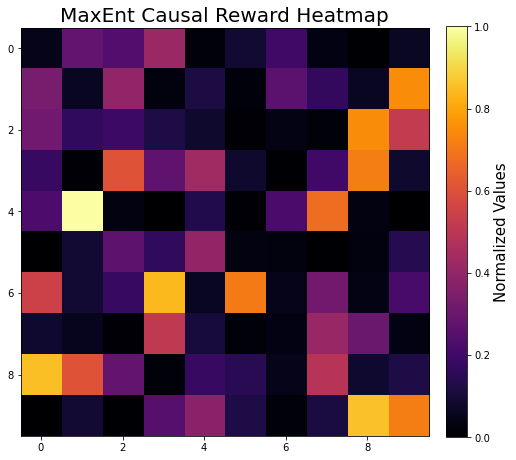

In [409]:
reshaped_rewards = normalized_reward_maxent_causal.reshape((10, 10))

fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(reshaped_rewards, cmap='inferno')
ax.set_title("MaxEnt Causal Reward Heatmap", fontsize = 20)
colorbar = fig.colorbar(im, fraction=0.046, pad=0.04)
colorbar.set_label(label = "Normalized Values", fontsize = 15)

In [410]:
cluster_sizes = np.zeros(100)

for i in range(num_clusters):
    cluster_sizes[i] = (len(X_df.loc[X_df['cluster'] == i]))
    
sum_points = 0

print(len(X_df))

for i in range(num_clusters):    
#     print(cluster_sizes[i])
    sum_points += cluster_sizes[i]

print(sum_points)

355504
355504.0


/var/folders/14/zdcxt99s1kv_hw67vpgm8f640000gn/T/ipykernel_56385/415261642.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


[Text(-2000.0, 0, '-2,000'),
 Text(0.0, 0, '0'),
 Text(2000.0, 0, '2,000'),
 Text(4000.0, 0, '4,000'),
 Text(6000.0, 0, '6,000'),
 Text(8000.0, 0, '8,000'),
 Text(10000.0, 0, '10,000')]

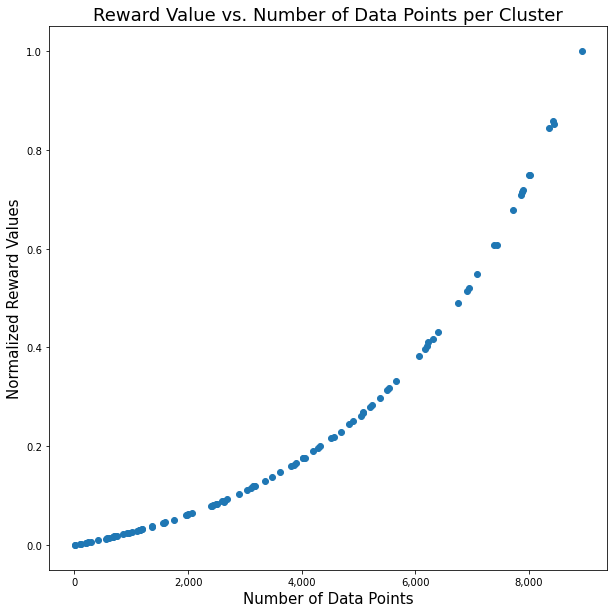

In [411]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(cluster_sizes, normalized_reward_maxent_causal)
ax.set_title("Reward Value vs. Number of Data Points per Cluster", fontsize=18)
ax.set_xlabel("Number of Data Points", fontsize = 15)
ax.set_ylabel("Normalized Reward Values", fontsize = 15)


current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

# Computing the policy induced by your learnt reward

In [412]:
V, Q = S.value_iteration(p_transition, reward_maxent_causal, discount)

In [33]:
Q = Q.reshape((4, num_clusters))

In [34]:
soft_pi_mce = (np.exp(Q)/ np.sum(np.exp(Q), axis = 0)).T

In [35]:
soft_pi_mce

array([[0.25915716, 0.09616153, 0.42627804, 0.21840327],
       [0.23267453, 0.18581447, 0.32974777, 0.25176322],
       [0.2048565 , 0.25981003, 0.17993809, 0.35539537],
       [0.46562245, 0.30461175, 0.10967118, 0.12009461],
       [0.11813898, 0.0619814 , 0.49935001, 0.32052961],
       [0.37660329, 0.52323665, 0.02617474, 0.07398532],
       [0.57367943, 0.17448047, 0.10310351, 0.14873659],
       [0.11439677, 0.11933313, 0.44840874, 0.31786135],
       [0.05717088, 0.2205141 , 0.39166958, 0.33064543],
       [0.09431144, 0.04897025, 0.64860529, 0.20811303],
       [0.64053625, 0.29284316, 0.02689954, 0.03972106],
       [0.23027129, 0.05574018, 0.49511213, 0.2188764 ],
       [0.35996658, 0.29743227, 0.1230119 , 0.21958924],
       [0.04408678, 0.0362375 , 0.51841735, 0.40125837],
       [0.20433667, 0.20124478, 0.36142002, 0.23299853],
       [0.07172022, 0.03607155, 0.67233318, 0.21987505],
       [0.31340397, 0.22451299, 0.27107324, 0.19100979],
       [0.1715711 , 0.13226192,

/var/folders/14/zdcxt99s1kv_hw67vpgm8f640000gn/T/ipykernel_56385/2891833500.py:6: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  ax.pie(soft_pi_mce[i], labels=labels, autopct='%1.1f%%', textprops={'fontsize': 17})


Text(0.5, 0.98, 'MCE Policy')

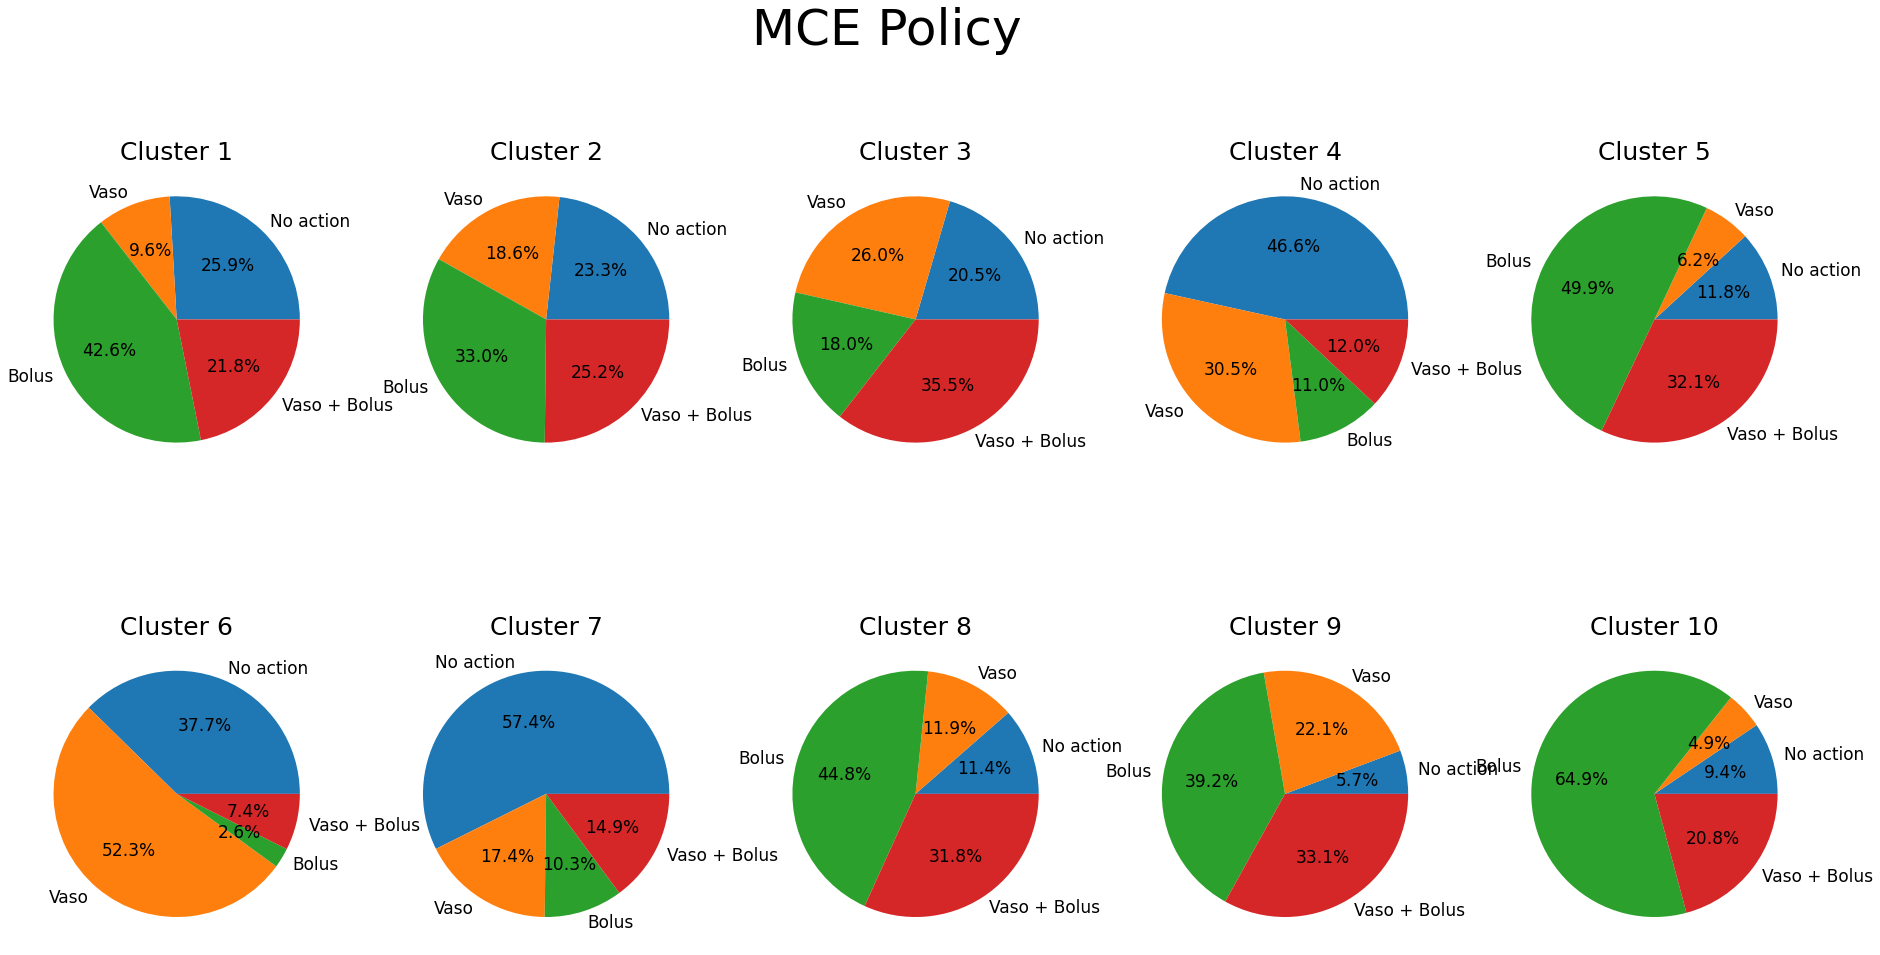

In [200]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(32, 16))

labels = ['No action', 'Vaso', 'Bolus', 'Vaso + Bolus']

for i, ax in enumerate(axes.flatten()):
    ax.pie(soft_pi_mce[i], labels=labels, autopct='%1.1f%%', textprops={'fontsize': 17})
    ax.set_title('Cluster ' + str(i+ 1), fontsize=25)

fig.suptitle("MCE Policy", fontsize=50)

In [413]:
policy_mce = np.argmax(Q, axis = 0).reshape(-1, )

In [414]:
policy_mce

array([2, 2, 3, 0, 2, 1, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 0, 3, 2, 1, 0, 3,
       1, 0, 1, 2, 2, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 1, 2, 0, 0, 2, 2,
       0, 2, 2, 1, 2, 2, 1, 2, 2, 3, 1, 2, 2, 2, 2, 3, 1, 2, 0, 1, 0, 1,
       0, 0, 2, 0, 1, 2, 2, 1, 2, 0, 0, 1, 0, 2, 0, 1, 0, 1, 2, 0, 2, 1,
       2, 0, 0, 2, 2, 0, 0, 0, 3, 3, 1, 1])

# adding policy actions to bigass plot

In [415]:
bc_action = []
for i in color_matrix_x_labels:
    bc_action.append(bc_policy[i])

print(bc_action)

mce_action = []
for i in color_matrix_x_labels:
    mce_action.append(policy_mce[i])

print(mce_action)

[0, 0, 0, 0, 0, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 1, 2, 2, 2, 1, 0]


In [420]:
color_matrix = color_matrix.tolist()

In [421]:
color_matrix.append(bc_action)
color_matrix.append(mce_action)

In [422]:
len(color_matrix)

16

In [423]:
color_matrix_y_labels.append('bc_action')
color_matrix_y_labels.append('mce_action')

In [424]:
color_matrix_y_labels

['creatinine',
 'fraction_inspired_oxygen',
 'lactate',
 'urine_output',
 'alanine_aminotransferase',
 'asparate_aminotransferase',
 'mean_blood_pressure',
 'diastolic_blood_pressure',
 'systolic_blood_pressure',
 'gcs',
 'partial_pressure_of_oxygen',
 'heart_rate',
 'temperature',
 'respiratory_rate',
 'bc_action',
 'mce_action']

In [425]:
len(color_matrix_y_labels)
print(color_matrix_y_labels)

['creatinine', 'fraction_inspired_oxygen', 'lactate', 'urine_output', 'alanine_aminotransferase', 'asparate_aminotransferase', 'mean_blood_pressure', 'diastolic_blood_pressure', 'systolic_blood_pressure', 'gcs', 'partial_pressure_of_oxygen', 'heart_rate', 'temperature', 'respiratory_rate', 'bc_action', 'mce_action']


In [426]:
normalized_color_matrix = color_matrix
normalized_color_matrix

[[1.4483086917562698,
  1.5575204942378529,
  1.5526671408250399,
  1.4686961206896556,
  1.5458614653663452,
  2.3323232323232324,
  2.231666666666666,
  1.7024999999999997,
  1.6111111111111116,
  3.4],
 [0.4867480585424222,
  0.4907413567779646,
  0.49231191718035333,
  0.49897529533845264,
  0.4888426273235139,
  0.6172222222222219,
  0.6966666666666665,
  0.5289999999999996,
  0.48055555555555557,
  0.375],
 [1.878915770609301,
  2.050729080036423,
  1.8441935356408885,
  1.9591056034482628,
  2.0313453363340903,
  8.227861952861955,
  7.867916666666672,
  3.190000000000003,
  2.288888888888889,
  5.300000000000001],
 [111.10105846774194,
  103.91063720248704,
  111.11039987355777,
  108.10428639846745,
  100.21892973243312,
  46.34848484848485,
  31.433333333333334,
  106.72,
  66.44444444444444,
  37.5],
 [155.24137544802866,
  137.7306641321136,
  156.47700331910858,
  115.4673132183908,
  107.77256814203551,
  767.8838383838383,
  376.10833333333335,
  443.86,
  677.2222222222

In [427]:
for i in range(len(normalized_color_matrix)):
    lst = normalized_color_matrix[i]
    max_val = max(lst)
    min_val = min(lst)
    if color_matrix_y_labels[i] == 'bc_action' or color_matrix_y_labels[i] == 'mce_action':
        max_val = 3
        min_val = 0
    dif = max_val - min_val
    for j in range(len(lst)):
        normalized_color_matrix[i][j] = normalized_color_matrix[i][j]-min_val
        normalized_color_matrix[i][j] = normalized_color_matrix[i][j]/dif        

In [428]:
normalized_color_matrix

[[0.0,
  0.05595751849705148,
  0.053470776156030145,
  0.01044603152520667,
  0.049983710640111575,
  0.4529479312804141,
  0.4013739117459703,
  0.13024155365659196,
  0.08341607029102516,
  1.0],
 [0.34740329080545773,
  0.35981768946517506,
  0.364700260664311,
  0.3854154259226508,
  0.3539149035964164,
  0.7530224525043171,
  1.0,
  0.4787564766839367,
  0.32815198618307445,
  0.0],
 [0.005439229091965851,
  0.03235373940137123,
  0.0,
  0.01800094558441958,
  0.02931728098350581,
  1.0,
  0.943614664379455,
  0.21082023319515864,
  0.06966141161849147,
  0.54135118532104],
 [0.999882759164946,
  0.9096382060271261,
  1.0,
  0.9622712832484527,
  0.8633048301844025,
  0.18719503820615313,
  0.0,
  0.9448975713564793,
  0.43941265198858676,
  0.07614068803102773],
 [0.0750944883700567,
  0.04865859078137193,
  0.07695991412394397,
  0.015047639511722112,
  0.003430893102072641,
  1.0,
  0.4085370409906064,
  0.5108216420641699,
  0.8631282786385263,
  0.0],
 [0.06874782996820028,


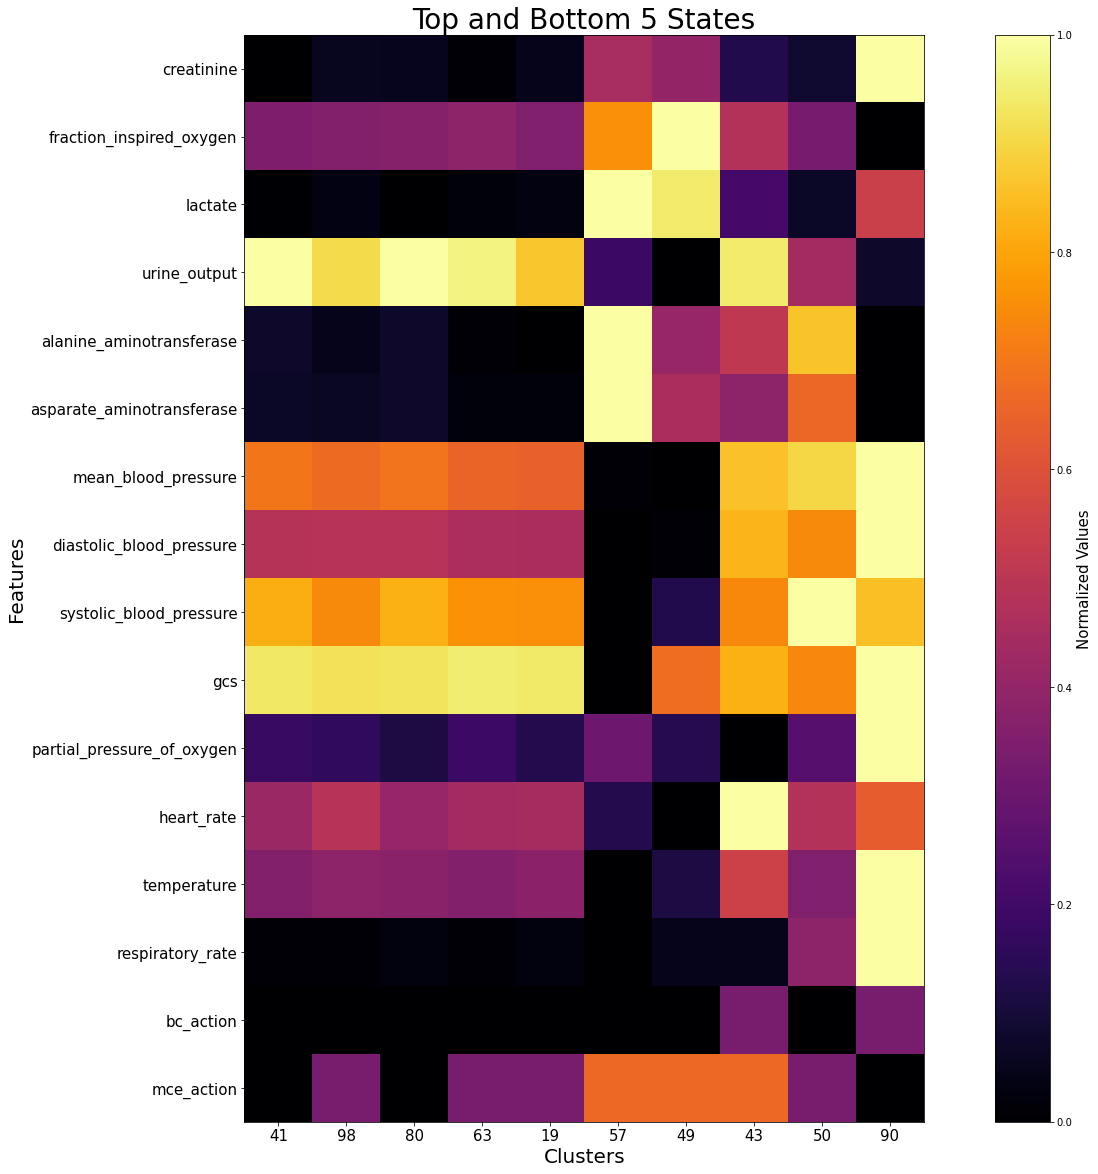

In [429]:
fig, ax = plt.subplots(figsize=(32,20))
im = ax.imshow(color_matrix, cmap='inferno')
ax.set_title("Top and Bottom 5 States", fontsize = 28)
ax.set_yticks(np.arange(0, 16, 1))
ax.set_yticklabels(color_matrix_y_labels, fontsize = 15)
ax.set_xticks(np.arange(0, 10, 1))
ax.set_xticklabels(color_matrix_x_labels, fontsize = 15)
ax.set_ylabel('Features', fontsize = 20)
ax.set_xlabel('Clusters', fontsize = 20)
colorbar = fig.colorbar(im, fraction=0.046, pad=0.04)
colorbar.set_label(label = "Normalized Values", fontsize = 15)